<a href="https://colab.research.google.com/github/WiHi1131/Histopathologic-Cancer-Detection-Report/blob/main/Histopathic_Cancer_Detection_Report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to the Histopathologic Cancer Detection Challenge
William Hinkley

12/11/2023

CSPB3202

## Background
The Histopathologic Cancer Detection competition, hosted on Kaggle, presented a significant challenge in the field of medical image analysis. The competition began on November 16, 2018, and concluded on March 30, 2019. Its primary objective was to develop algorithms capable of identifying metastatic cancer from small image patches extracted from larger digital pathology scans. This report will detail my own attempt at identifying metastatic cancer from the same images as an exercise designed to showcase my knowledge and use of machine learning techniques.

## Dataset Overview and Key Characteristics
The dataset for this competition is a refined version of the PatchCamelyon (PCam) benchmark dataset, with duplicates removed for enhanced accuracy and challenge. This dataset is significant due to its size, simplicity, and potential for various machine learning research applications.

### Dataset Details:

- Size: The dataset includes a substantial number of images, making it suitable for training robust models.
  - Test Set: Contains 57,500 .tif images, each approximately 27.94 kB in size.
  - Training Set: Comprises 220,000 .tif images, with each image being of the same size as those in the test set.
- Data Structure:
  - Image Files: All images are in .tif format, which is common for high-quality pathology images.
  - Labels:
    - Training Labels: Provided in a train_labels.csv file. A positive label indicates the presence of tumor tissue in the central 32x32 pixel region of an image patch.
    - Sample Submission: A sample submission file in .csv format is included to guide the format of competition submissions.
- Clinical Relevance: The challenge focuses on detecting metastasis in pathology images, a critical task in cancer diagnosis.
- Task Design: The problem is structured as a binary image classification task, akin to other popular datasets like CIFAR-10 and MNIST.
- Feasibility for Training: Despite its large size, the dataset is structured to allow efficient training on standard hardware, including single GPU setups.
- Research Potential: The dataset's structure and challenge make it a valuable resource for exploring key areas in machine learning, including model uncertainty, active learning, and explainability.

## Acknowledgements
The dataset was provided by Bas Veeling, with additional contributions from Babak Ehteshami Bejnordi, Geert Litjens, and Jeroen van der Laak. It is essential to reference specific papers if this dataset is used in scientific publications.

##Evaluation Metric
The primary evaluation metric for this competition is the area under the Receiver Operating Characteristic (ROC) curve. This metric assesses the performance of the prediction models based on their ability to distinguish between the two classes: presence or absence of tumor tissue.

##Submission Format
Participants are required to predict the probability that the central 32x32 pixel region of each image patch contains at least one pixel of tumor tissue. The submission file should follow the format: id, label, where each id corresponds to an image in the test set, and label is the predicted probability.

This competition offers a unique opportunity to apply and enhance machine learning skills in a clinically significant domain, paving the way for advancements in medical diagnostics through AI.

# Importing Necessary Libraries, and Data Upload:

In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
from matplotlib.patches import Rectangle
import numpy as np
import random
from tensorflow import keras
from sklearn.model_selection import train_test_split
from PIL import Image
import tensorflow as tf
from tensorflow.keras import layers as Layers
from tensorflow.keras import models as Models
from tensorflow.keras import optimizers as Optimizer
from tensorflow.keras.utils import plot_model
import h5py

In [3]:
from google.colab import files

#kaggle.json
uploaded = files.upload()
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [4]:
!kaggle competitions download -c histopathologic-cancer-detection
import zipfile


100% 6.30G/6.31G [00:42<00:00, 245MB/s]
100% 6.31G/6.31G [00:42<00:00, 160MB/s]


In [5]:
with zipfile.ZipFile('/content/histopathologic-cancer-detection.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/histopathologic_dataset')

# Exploratory Data Analysis

We begin this EDA by displaying a few images labeled as both cancer and non-cancer, highlighting the center 32 x 32 px square in each image that determines whether or not the image receives a positive label or not:

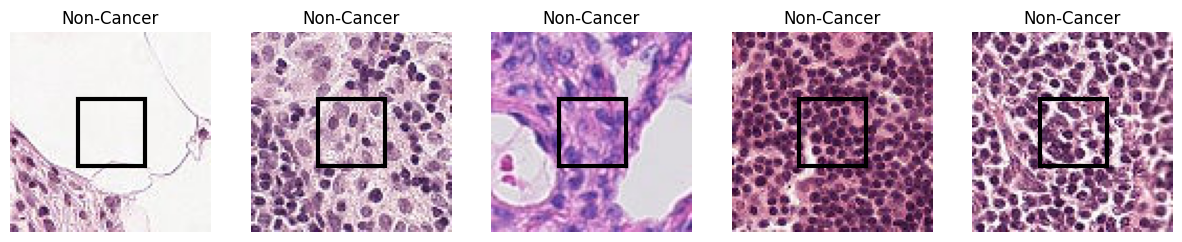

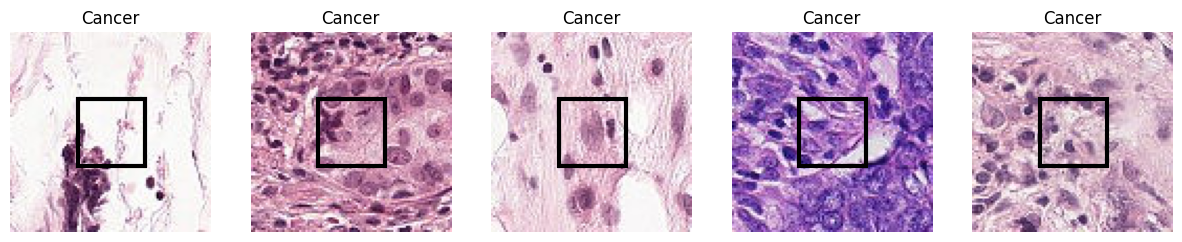

In [2]:
# Load the labels
labels_df = pd.read_csv('/content/histopathologic_dataset/train_labels.csv')

# Separate the images into two categories based on labels
cancer_images = labels_df[labels_df['label'] == 1]['id'].values
non_cancer_images = labels_df[labels_df['label'] == 0]['id'].values

# Function to display images with an emboldened yellow square around the center 32x32px
def display_images_with_emboldened_square(image_ids, title, n=5):
    plt.figure(figsize=(15, 5))
    for i, image_id in enumerate(image_ids[:n]):
        img_path = os.path.join('/content/histopathologic_dataset/train', image_id + '.tif')
        img = mpimg.imread(img_path)
        plt.subplot(1, n, i + 1)
        plt.imshow(img)
        plt.title(title)
        plt.axis('off')

        # Calculate the coordinates for the center square
        img_height, img_width, _ = img.shape
        x_center, y_center = img_width // 2, img_height // 2
        rectangle = Rectangle((x_center - 16, y_center - 16), 32, 32,
                              linewidth=3, edgecolor='black', facecolor='none')
        plt.gca().add_patch(rectangle)

    plt.show()

# Display a subset of non-cancer images with emboldened yellow square
display_images_with_emboldened_square(non_cancer_images, 'Non-Cancer', n=5)

# Display a subset of cancer images with emboldened yellow square
display_images_with_emboldened_square(cancer_images, 'Cancer', n=5)

Examining this subset of images does not reveal much information for a non-trained, non-medical professional. In other words, I have no idea what distinguishes a cancerous image from a non-cancerous one by looking at these images alone. Below, we isolate the 32 x 32 pixel sections that determine whether or not an image receives a label and enlarge it, to look for any additional clues:

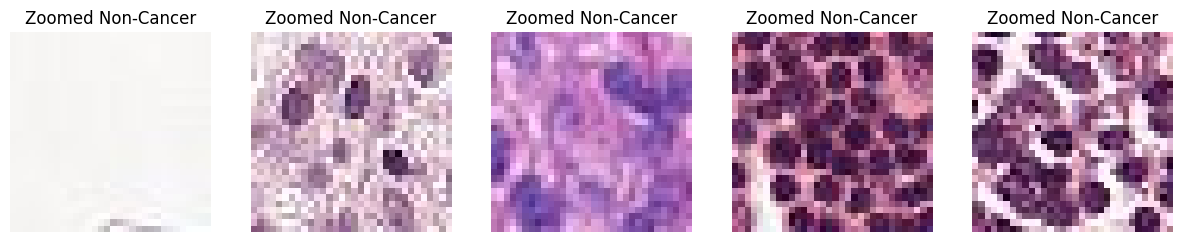

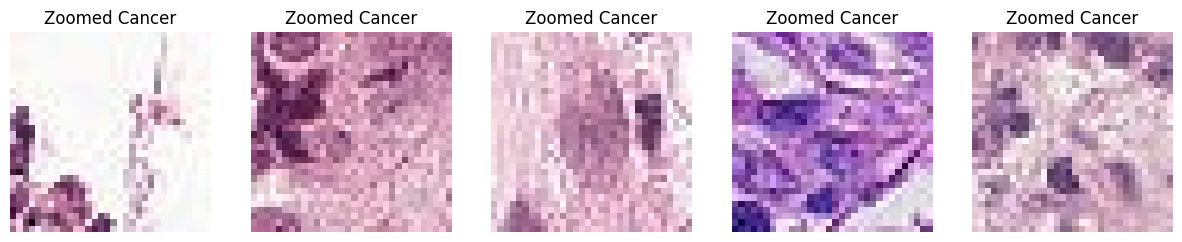

In [3]:
# Function to display the central 32x32px section of images
def display_zoomed_center(image_ids, title, n=5):
    plt.figure(figsize=(15, 5))
    for i, image_id in enumerate(image_ids[:n]):
        img_path = os.path.join('/content/histopathologic_dataset/train', image_id + '.tif')
        img = mpimg.imread(img_path)

        # Calculate the coordinates for the center square and crop
        img_height, img_width, _ = img.shape
        x_center, y_center = img_width // 2, img_height // 2
        cropped_img = img[y_center - 16:y_center + 16, x_center - 16:x_center + 16]

        plt.subplot(1, n, i + 1)
        plt.imshow(cropped_img)
        plt.title(title)
        plt.axis('off')

    plt.show()

# Display the zoomed center of non-cancer images
display_zoomed_center(non_cancer_images, 'Zoomed Non-Cancer', n=5)

# Display the zoomed center of cancer images
display_zoomed_center(cancer_images, 'Zoomed Cancer', n=5)

Unfortunately, the images above are very pixellated and difficult to determine any significant details from. We can conclude that our analysis should focus on finding less-obvious distinguishing details from these images or features not readily apparent to the naked eye.

Let's begin by examining the distribution of labels within the training data, looking for any class imbalance:

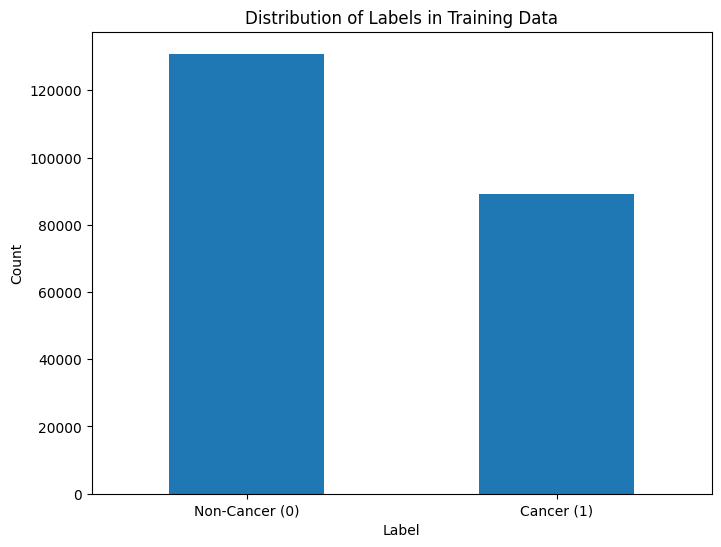

In [4]:
# Count the number of instances of each label
label_counts = labels_df['label'].value_counts()

# Plotting
plt.figure(figsize=(8, 6))
label_counts.plot(kind='bar')
plt.title('Distribution of Labels in Training Data')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Non-Cancer (0)', 'Cancer (1)'], rotation=0)  # Set custom labels for x-axis ticks
plt.show()

In [5]:
# Calculate the ratio of class imbalance
non_cancer_count = label_counts[0]
cancer_count = label_counts[1]
imbalance_ratio = non_cancer_count / cancer_count

# Printing the counts and ratio
print(f"Number of Non-Cancer samples: {non_cancer_count}")
print(f"Number of Cancer samples: {cancer_count}")
print(f"Class Imbalance Ratio (Non-Cancer to Cancer): {imbalance_ratio:.2f}")

Number of Non-Cancer samples: 130908
Number of Cancer samples: 89117
Class Imbalance Ratio (Non-Cancer to Cancer): 1.47


The above plot and printed ratio shows us some class imbalance, with almost 1.5 times more non-cancerous images than cancerous. We would like to ensure our classes are balanced when we conduct our analysis later. Therefore, let's conduct undersampling of the non-cancerous images to match the number of cancerous images so we have completely equal class ratio. This may result in a loss of some data, but the classes are not too far apart in terms of imbalance ratio, the image dataset is very large, and we are not removing most of the data, only some, so this risk is worth the less-skewed results we hope to achieve in further analysis. We do so below:

In [6]:
# Separate the data into cancer and non-cancer datasets
cancer_df = labels_df[labels_df['label'] == 1]
non_cancer_df = labels_df[labels_df['label'] == 0]

# Number of samples to match
num_samples_to_match = len(cancer_images)

# Randomly sample non-cancerous images to match the number of cancerous images
balanced_non_cancer_df = non_cancer_df.sample(n=num_samples_to_match, random_state=42)

# Combine the balanced datasets
balanced_dataset = pd.concat([cancer_df, balanced_non_cancer_df])

# Shuffle the combined dataset
balanced_dataset = balanced_dataset.sample(frac=1, random_state=42).reset_index(drop=True)

# Save the balanced dataset if needed
# balanced_dataset.to_csv('/content/histopathologic_dataset/train_labels_balanced.csv', index=False)

print("Number of samples in the balanced dataset:", len(balanced_dataset))
print(balanced_dataset['label'].value_counts())

Number of samples in the balanced dataset: 178234
0    89117
1    89117
Name: label, dtype: int64


Now that we have balanced the training data we will train our models on, let us examine some properties of that data. Below, we plot the frequency of color intensity values of the central 32 x 32 pixel sections of approximately 1% of each class of image, sampled randomly:

In [12]:
def crop_and_save_images(image_ids, save_path, dataset_name):
    with h5py.File(save_path, 'w') as hf:
        for i, image_id in enumerate(image_ids):
            img_path = os.path.join('/content/histopathologic_dataset/train', image_id + '.tif')
            img = Image.open(img_path)

            # Crop to the center 32x32px
            img_width, img_height = img.size
            x_center, y_center = img_width // 2, img_height // 2
            cropped_img = img.crop((x_center - 16, y_center - 16, x_center + 16, y_center + 16))

            # Convert to numpy array and normalize
            np_img = np.array(cropped_img) / 255.0

            # Save each cropped image to the HDF5 file
            hf.create_dataset(f'{dataset_name}/{i}', data=np_img)

# Usage
image_ids = balanced_dataset['id'].values
crop_and_save_images(image_ids, '/content/cropped_images.h5', 'cropped_images')

In [7]:
def load_cropped_images(hdf5_path, dataset_name):
    with h5py.File(hdf5_path, 'r') as hf:
        # Create an empty array with the correct shape
        num_images = len(hf[dataset_name])
        # Assuming each image is 32x32 with 3 channels
        images = np.empty((num_images, 32, 32, 3), dtype=np.float32)

        # Load each image into the array
        for i in range(num_images):
            images[i] = hf[f'{dataset_name}/{i}'][:]

    return images
# Usage
cropped_images = load_cropped_images('/content/cropped_images.h5', 'cropped_images')

# Now, cropped_images should be a 4D numpy array with shape (num_samples, 32, 32, 3)
print("Shape of loaded images:", cropped_images.shape)

# Convert to numpy array
Images = np.array(cropped_images)

# Now Images is a numpy array containing all cropped images

Shape of loaded images: (178234, 32, 32, 3)


In [8]:
# Split the data into training and validation sets
train_images, val_images, train_labels, val_labels = train_test_split(
    Images,
    balanced_dataset['label'].values,
    test_size=0.2,
    random_state=42
)

# Convert labels to numpy arrays
train_labels = np.array(train_labels)
val_labels = np.array(val_labels)

In [9]:
model = Models.Sequential([
    Layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    Layers.MaxPooling2D((2, 2)),
    Layers.Conv2D(64, (3, 3), activation='relu'),
    Layers.MaxPooling2D((2, 2)),
    Layers.Conv2D(64, (3, 3), activation='relu'),
    Layers.Flatten(),
    Layers.Dense(64, activation='relu'),
    Layers.Dense(1, activation='sigmoid')
])

In [10]:
model.compile(optimizer=Optimizer.Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [11]:
history = model.fit(train_images, train_labels, epochs=10,
                    validation_data=(val_images, val_labels))


Epoch 1/10
4456/4456 [==============================] - 44s 7ms/step - loss: 0.5096 - accuracy: 0.7593 - val_loss: 0.4839 - val_accuracy: 0.7778
Epoch 2/10
4456/4456 [==============================] - 27s 6ms/step - loss: 0.4640 - accuracy: 0.7868 - val_loss: 0.4622 - val_accuracy: 0.7908
Epoch 3/10
4456/4456 [==============================] - 27s 6ms/step - loss: 0.4466 - accuracy: 0.7962 - val_loss: 0.4478 - val_accuracy: 0.7968
Epoch 4/10
4456/4456 [==============================] - 27s 6ms/step - loss: 0.4347 - accuracy: 0.8030 - val_loss: 0.4520 - val_accuracy: 0.7885
Epoch 5/10
4456/4456 [==============================] - 26s 6ms/step - loss: 0.4252 - accuracy: 0.8077 - val_loss: 0.4300 - val_accuracy: 0.8047
Epoch 6/10
4456/4456 [==============================] - 27s 6ms/step - loss: 0.4161 - accuracy: 0.8126 - val_loss: 0.4497 - val_accuracy: 0.7927
Epoch 7/10
4456/4456 [==============================] - 27s 6ms/step - loss: 0.4079 - accuracy: 0.8164 - val_loss: 0.4232 - val_ac